### Identify Customer Segments k-Means - Work in Progress
- Data Cleaning + Transformation
- Define Optimal Number of Clusters (Silhouette / Elbow)
- Build the model
- Link to data https://www.kaggle.com/datasets/tunguz/online-retail
- Project Inspiration from:https://towardsdatascience.com/data-driven-customer-segmentation-c16062741a7c

Next Steps:
- Conduct deep dive EDA to get insights for feature engineering
- Get more business value from clustering

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

### Data Cleaning

In [2]:
data = pd.read_csv('/Users/jennihawk/Documents/Data Science3/Clustering Project/Online_Retail.csv', encoding='latin1', parse_dates=["InvoiceDate"]) 

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
#drop nulls
data_clean = data.dropna()

In [7]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
# Remove negative quantity
# check how many rows it dropped
data_clean = data_clean.loc[data_clean['Quantity'] > 0]
# Remove rows with negative price
data_clean = data_clean.loc[data_clean['UnitPrice'] > 0]
# Handle incomplete data: dec 2011 not complete dataset
data_clean = data_clean.loc[data_clean['InvoiceDate'] < '2011-12-01']

In [9]:
data_clean.shape

(380580, 8)

### Data Transformation

In [10]:
# Calculate total sales
data_clean['Sales'] = data_clean['Quantity'] * data_clean['UnitPrice']

In [39]:
# distribution of quanity

In [11]:
data_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [41]:
data_clean.Quantity.describe()

count    380580.000000
mean         12.823582
std         127.733673
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       74215.000000
Name: Quantity, dtype: float64

In [43]:
data_clean[data_clean.Quantity > 10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


#### Create per-customer data

In [12]:
# sum sales by customer ID, gather unique invoice numbers
# 'CustomerID' becomes index

df_customers = data_clean.groupby('CustomerID').agg({'Sales': sum, 
                                                     'InvoiceNo': lambda x: x.unique()})

In [13]:
df_customers.head()

,Sales,InvoiceNo
CustomerID,,
12346.0,77183.60,[541431]
12347.0,4085.18,"[537626, 542237, 549222, 556201, 562032, 573511]"
12348.0,1797.24,"[539318, 541998, 548955, 568172]"
12349.0,1757.55,[577609]
12350.0,334.40,[543037]


In [14]:
df_customers['OrderCount'] = df_customers.InvoiceNo.apply(lambda x: len(x))

In [15]:
df_customers.head()

,Sales,InvoiceNo,OrderCount
CustomerID,,,
12346.0,77183.60,[541431],1
12347.0,4085.18,"[537626, 542237, 549222, 556201, 562032, 573511]",6
12348.0,1797.24,"[539318, 541998, 548955, 568172]",4
12349.0,1757.55,[577609],1
12350.0,334.40,[543037],1


In [16]:
df_customers['AvgOrderValue'] = df_customers['Sales'] / df_customers['OrderCount']

In [17]:
df_customers.head()

,Sales,InvoiceNo,OrderCount,AvgOrderValue
CustomerID,,,,
12346.0,77183.60,[541431],1,77183.600000
12347.0,4085.18,"[537626, 542237, 549222, 556201, 562032, 573511]",6,680.863333
12348.0,1797.24,"[539318, 541998, 548955, 568172]",4,449.310000
12349.0,1757.55,[577609],1,1757.550000
12350.0,334.40,[543037],1,334.400000


In [18]:
df_customers.shape

(4297, 4)

#### Dataframe that contains only columns needed for modeling

In [19]:
new_df = df_customers[['Sales','OrderCount','AvgOrderValue']].copy()

In [20]:
new_df

,Sales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
...,...,...,...
18280.0,180.60,1,180.600000
18281.0,80.82,1,80.820000
18282.0,100.21,1,100.210000


### Normalize data
- normalize the data to center around the mean 
- have a mean of 0 and a standard deviation of 1

In [21]:
# Rank the data
# manual calculating z score 
df_rank = new_df.rank(method='first')

# Let us normalize the data to center around the mean 
# and have a mean of 0 and a standard deviation of 1
df_normalized = (df_rank - df_rank.mean()) / df_rank.std()

In [22]:
#alternative
#X_std = StandardScaler().fit_transform(new_df)

### Defining Optimal Number of Clusters

#### Elbow Method
- Distortion: the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
- Inertia: It is the sum of squared distances of samples to their closest cluster center.

/var/folders/_0/21d2kw097h912yp8tr3nkrsm0000gn/T/ipykernel_4540/585329504.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, distortions, 'bx-',  linewidth=2.5, color='dodgerblue')


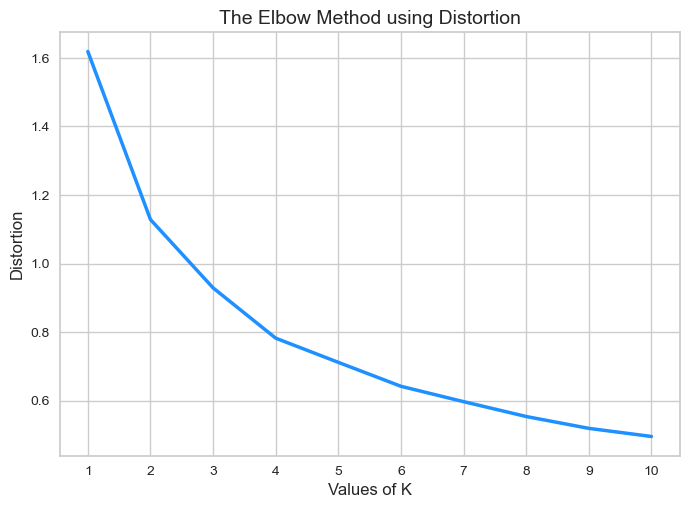

In [23]:
# Calculate inertias and distortions for customers dataset
# Link to original code: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = [] 
inertias = []
K=range(1, 11)

for k in K: 
    kmeanModel = KMeans(n_clusters=k, max_iter=400, n_init=20).fit(df_normalized[['Sales',
                                                                                  'OrderCount',
                                                                                  'AvgOrderValue']]) 
    kmeanModel.fit(df_normalized[['Sales', 'OrderCount', 'AvgOrderValue']])
    distortions.append(sum(np.min(cdist(df_normalized[['Sales',
                                                       'OrderCount',
                                                       'AvgOrderValue']],
                                        kmeanModel.cluster_centers_,
                                        'euclidean'),axis=1)) / df_normalized[['Sales',
                                                                               'OrderCount',
                                                                               'AvgOrderValue']].shape[0]) 
    inertias.append(kmeanModel.inertia_)

# Plot distortions
plt.plot(K, distortions, 'bx-',  linewidth=2.5, color='dodgerblue') 
plt.xlabel('Values of K', fontsize=12) 
plt.ylabel('Distortion', fontsize=12) 
plt.title('The Elbow Method using Distortion', fontsize=14) 
plt.xticks(np.arange(1, 11))
plt.show()

/var/folders/_0/21d2kw097h912yp8tr3nkrsm0000gn/T/ipykernel_4540/1996611138.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertias, 'bx-', linewidth=2.5, color='dodgerblue')


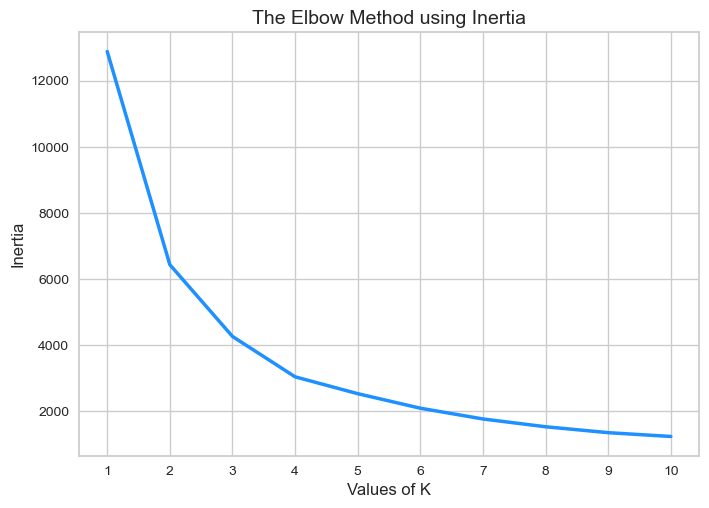

In [24]:
# Plot inertias
plt.plot(K, inertias, 'bx-', linewidth=2.5, color='dodgerblue') 
plt.xlabel('Values of K', fontsize=12) 
plt.ylabel('Inertia', fontsize=12) 
plt.title('The Elbow Method using Inertia', fontsize=14) 
plt.xticks(np.arange(1, 11))
plt.show()

#### Silhouette Coefficient
The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its own cluster compared to other clusters.
#### Silhouette Coefficient Analysis
- In terms of finding well-defined, well-separated clusters, higher coefficients are better.
- A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 
- If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [25]:
# Silhouette Coefficient
# goodness of clustering technique. Coefficient ranges from -1 to 1 closer to 1 the better.
for n_cluster in [2, 3, 4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_cluster,
                    max_iter=400,
                    n_init=20).fit(df_normalized[['Sales',
                                                  'OrderCount',
                                                  'AvgOrderValue']])
    silhouette_avg = silhouette_score(df_normalized[['Sales',
                                                     'OrderCount',
                                                     'AvgOrderValue']],
                                      kmeans.labels_) 
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster,
                                                             silhouette_avg))

Silhouette coefficient for 2 clusters: 0.429
Silhouette coefficient for 3 clusters: 0.413
Silhouette coefficient for 4 clusters: 0.411
Silhouette coefficient for 5 clusters: 0.377
Silhouette coefficient for 6 clusters: 0.378
Silhouette coefficient for 7 clusters: 0.391
Silhouette coefficient for 8 clusters: 0.381


#### Silhouette Visualization 4 Clusters
- Documentation https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

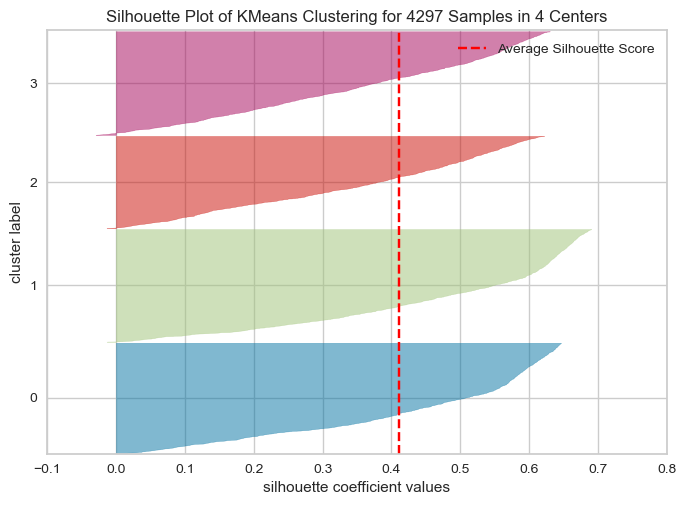

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 4297 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
# Instantiate the clustering model and visualizer
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


#### InterCluster Distance

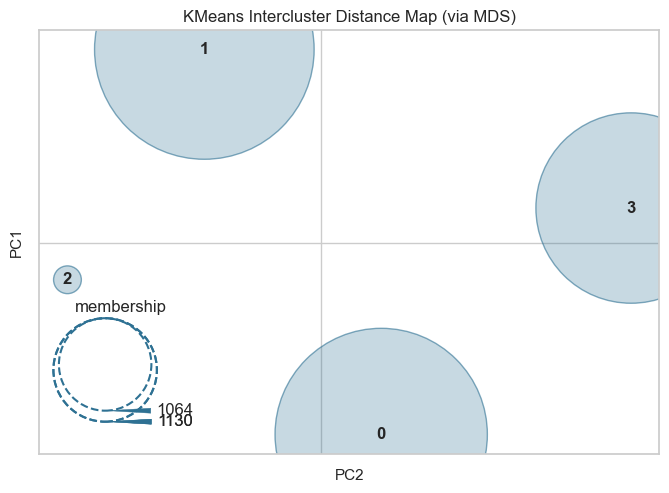

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [27]:
model = KMeans(4, random_state=42)
visualizer = InterclusterDistance(model, colors='yellowbrick')

visualizer.fit(df_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


### Build K-means model
- n_init: number of times k-means to run with different starting points. Each run of k-means will have a different random starting configuration for the centroids. k-means can then pick the best solution from the results of these starting configurations
- n_init default = 10: k-means will be run from 10 different starting configurations for the centroids. Then the solution with best fit will be selected among the 10 different clusters
- The best fit as measured by inertia metric (measures how tight our cluster solutions are)
- max_iter default = 300. Max num of iterations of the k-means algorithm for a single run

In [28]:
kmeans = KMeans(n_clusters=4,
                max_iter=400,
                n_init=20).fit(df_normalized[['Sales',
                                              'OrderCount',
                                              'AvgOrderValue']])

#### Create dataframe that: 
- assigns each customer with its cluster
- shows Coordinates of cluster centers of each feature

In [29]:
cluster_centres = kmeans.cluster_centers_

df_cluster_centres = pd.DataFrame(cluster_centres,
                                  columns=['Sales', 
                                           'OrderCount',
                                           'AvgOrderValue'])
df_cluster_centres['Cluster'] = df_cluster_centres.index

df_four_clusters = df_normalized[['Sales',
                                  'OrderCount',
                                  'AvgOrderValue']].copy(deep=True)
# labels_ Each instance is assigned to one of the four clusters. 
# It receives a label as the index of the cluster it gets assigned to
df_four_clusters['Cluster'] = kmeans.labels_

In [30]:
df_four_clusters

,Sales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724998,-1.731446,1.731446,2
12347.0,1.457381,1.064017,1.400956,1
12348.0,0.967288,0.573118,0.929403,1
12349.0,0.943912,-1.730640,1.683082,2
12350.0,-0.732721,-1.729834,0.331296,2
...,...,...,...,...
18280.0,-1.272790,-0.494123,-0.852020,0
18281.0,-1.649227,-0.493317,-1.596832,0
18282.0,-1.605699,-0.492511,-1.518643,0


#### Number of Customers in each cluster

In [31]:
df_four_clusters['Cluster'].value_counts()

0    1173
1    1126
2    1066
3     932
Name: Cluster, dtype: int64

### Analysis for each cluster's center

In [32]:
df_cluster_centres

,Sales,OrderCount,AvgOrderValue,Cluster
0,-1.231400,-0.781098,-1.053157,0
1,1.205560,1.002073,0.875986,1
2,-0.132548,-0.848102,0.796083,2
3,0.247536,0.744372,-0.641312,3


#### Cluster 0: Lowest Value Customers
- Customers with:  lowest total sales dollars, lowest order count, and the lowest avg order value of all clusters

#### Cluster 1: Highest Value Customers
Customers with: highest total sales dollars, highest order count, and the highest avg order value of all clusters

#### Cluster 2: High Avg Order Value - Low Total Sales Dollars - Low Order Count
- Customers with: low total sales dollars, low order count, but high avg order value

#### Cluster 3: Low Avg Order Value - Low Total Sales Dollars - High Order Count 
- Customers with: low total sales dollars, high order count, low average order value

#### Visualize Segments

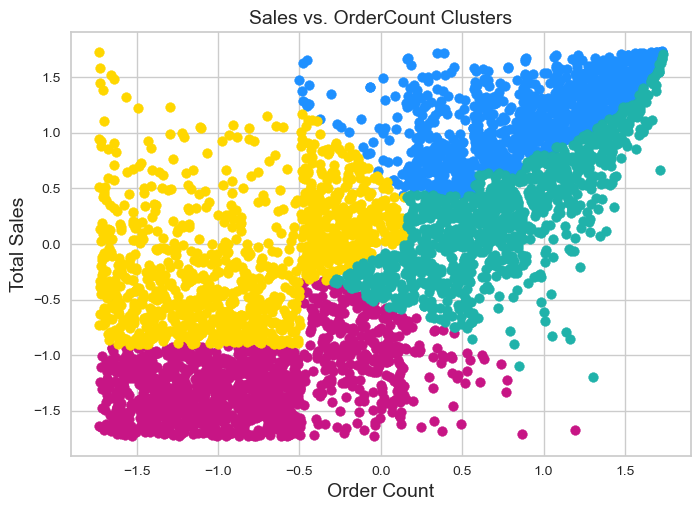

In [33]:
plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['Sales'],
            c='mediumvioletred')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['Sales'],
            c='dodgerblue')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['Sales'],
            c='gold')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['Sales'],
            c='lightseagreen')

plt.title('Sales vs. OrderCount Clusters', fontsize=14)
plt.xlabel('Order Count', fontsize=14)
plt.ylabel('Total Sales', fontsize=14);

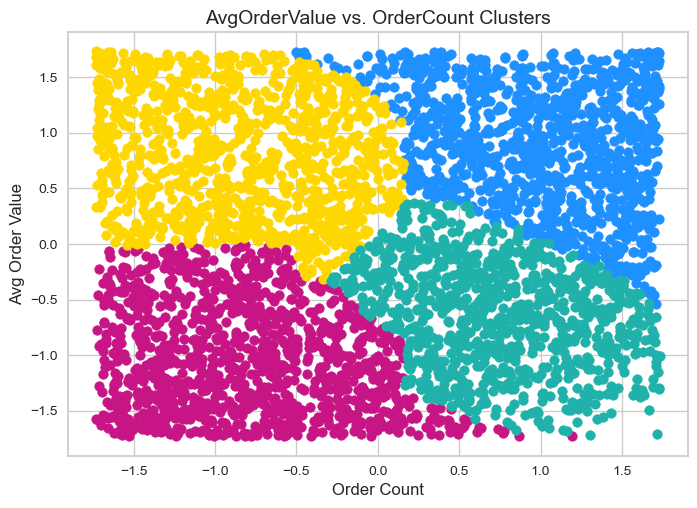

In [34]:
plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['AvgOrderValue'],
            c='mediumvioletred')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['AvgOrderValue'],
            c='dodgerblue')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['AvgOrderValue'],
            c='gold')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['OrderCount'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['AvgOrderValue'],
            c='lightseagreen')

plt.title('AvgOrderValue vs. OrderCount Clusters', fontsize=14)
plt.xlabel('Order Count', fontsize=12)
plt.ylabel('Avg Order Value', fontsize=12);

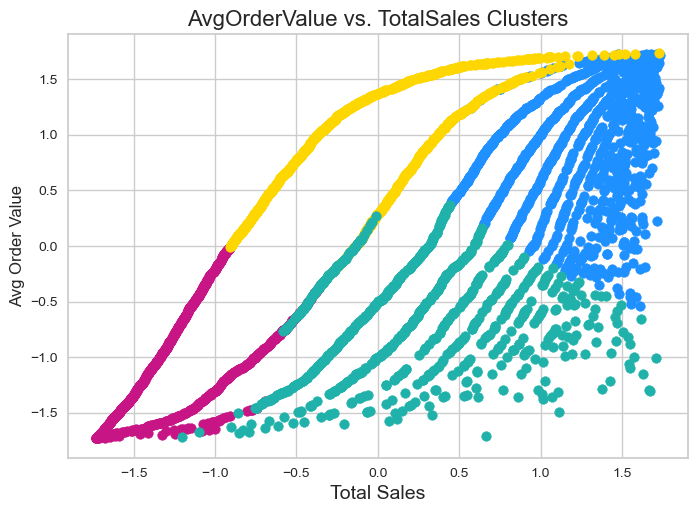

In [35]:
plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['Sales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 0]['AvgOrderValue'],
            c='mediumvioletred')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['Sales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 1]['AvgOrderValue'],
            c='dodgerblue')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['Sales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 2]['AvgOrderValue'],
            c='gold')

plt.scatter(df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['Sales'], 
            df_four_clusters.loc[df_four_clusters['Cluster'] == 3]['AvgOrderValue'],
            c='lightseagreen')

plt.title('AvgOrderValue vs. TotalSales Clusters', fontsize=16)
plt.xlabel('Total Sales', fontsize=14)
plt.ylabel('Avg Order Value', fontsize=12);

### Look at the most popular purchases for each segment
- What are the trends? Do most popular differ by particular segment? If so, why?
- Based on insights create 'item recommender' strategies - hypothesis to test 

In [36]:
#starter code
# pd.DataFrame(
#     df.loc[df['CustomerID'].isin(high_value_cluster.index)
#           ].groupby('Description').count()['StockCode'].sort_values(ascending=False).head(10))